<a href="https://colab.research.google.com/github/Ritikkumar2000/Feedback_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("="*60)
print("SENTIMENT ANALYSIS MODEL TRAINING")
print("="*60)


SENTIMENT ANALYSIS MODEL TRAINING


In [6]:
# ========================
# 1. TEXT PREPROCESSING
# ========================

def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Join tokens back to text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [3]:
# ========================
# 2. LOAD SPLIT DATA
# ========================

print("\nLoading train and test datasets...")
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

print(f"\nTraining set distribution:")
print(train_df['Category'].value_counts())



Loading train and test datasets...
Training samples: 1022
Testing samples: 256

Training set distribution:
Category
Positive                    498
Negative                    253
Negative with Suggestion    142
Positive with Suggestion    129
Name: count, dtype: int64


In [7]:

# ========================
# 3. TEXT CLEANING
# ========================

print("\nCleaning text data...")
train_df['cleaned_feedback'] = train_df['feedback'].apply(clean_text)
test_df['cleaned_feedback'] = test_df['feedback'].apply(clean_text)

# Remove empty rows
train_df = train_df[train_df['cleaned_feedback'].str.len() > 0]
test_df = test_df[test_df['cleaned_feedback'].str.len() > 0]

print(f"Training samples after cleaning: {len(train_df)}")
print(f"Testing samples after cleaning: {len(test_df)}")



Cleaning text data...
Training samples after cleaning: 1022
Testing samples after cleaning: 256


In [8]:
# ========================
# 4. PREPARE X AND Y
# ========================

X_train = train_df['cleaned_feedback']
y_train = train_df['Category']

X_test = test_df['cleaned_feedback']
y_test = test_df['Category']

# Define class names
class_names = ['Positive', 'Negative', 'Negative with Suggestion', 'Positive with Suggestion']


In [9]:
# ========================
# 5. TF-IDF VECTORIZATION
# ========================

print("\n" + "="*60)
print("TF-IDF FEATURE EXTRACTION")
print("="*60)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Total features: {len(tfidf_vectorizer.get_feature_names_out())}")


TF-IDF FEATURE EXTRACTION

TF-IDF feature matrix shape: (1022, 4696)
Total features: 4696


In [10]:
# ========================
# 6. HANDLE CLASS IMBALANCE WITH SMOTE
# ========================

print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE")
print("="*60)

class_counts = y_train.value_counts()
print(f"\nOriginal class distribution:")
print(class_counts)

# Check imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("\nApplying SMOTE for balancing...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
    print(f"\nBalanced training samples: {len(y_train_balanced)}")
    print(f"Balanced distribution:")
    print(pd.Series(y_train_balanced).value_counts())
else:
    X_train_balanced = X_train_tfidf
    y_train_balanced = y_train
    print("\nNo significant imbalance. Skipping SMOTE.")



HANDLING CLASS IMBALANCE

Original class distribution:
Category
Positive                    498
Negative                    253
Negative with Suggestion    142
Positive with Suggestion    129
Name: count, dtype: int64

Imbalance ratio: 3.86:1

Applying SMOTE for balancing...

Balanced training samples: 1992
Balanced distribution:
Category
Negative                    498
Negative with Suggestion    498
Positive                    498
Positive with Suggestion    498
Name: count, dtype: int64


In [11]:
# ========================
# 7. MODEL TRAINING
# ========================

models_results = {}


In [12]:
# ------------------------
# Model 1: Logistic Regression (PRIMARY MODEL)
# ------------------------

print("\n" + "="*60)
print("TRAINING LOGISTIC REGRESSION (PRIMARY MODEL)")
print("="*60)

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, multi_class='ovr'),
    lr_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_balanced, y_train_balanced)

best_lr = lr_grid.best_estimator_
print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV F1-score: {lr_grid.best_score_:.4f}")

y_pred_lr = best_lr.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"\nTest Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=class_names))

models_results['Logistic Regression'] = {
    'model': best_lr,
    'accuracy': lr_accuracy,
    'predictions': y_pred_lr,
    'report': classification_report(y_test, y_pred_lr, target_names=class_names, output_dict=True)
}



TRAINING LOGISTIC REGRESSION (PRIMARY MODEL)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-score: 0.9504

Test Accuracy: 0.7070

Classification Report:
                          precision    recall  f1-score   support

                Positive       0.73      0.68      0.70        63
                Negative       0.46      0.33      0.39        36
Negative with Suggestion       0.76      0.92      0.83       125
Positive with Suggestion       0.55      0.34      0.42        32

                accuracy                           0.71       256
               macro avg       0.63      0.57      0.59       256
            weighted avg       0.68      0.71      0.69       256



In [13]:
# ------------------------
# Model 2: Random Forest (COMPARISON)
# ------------------------

print("\n" + "="*60)
print("TRAINING RANDOM FOREST (COMPARISON)")
print("="*60)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    n_iter=10,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random.fit(X_train_balanced, y_train_balanced)

best_rf = rf_random.best_estimator_
print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV F1-score: {rf_random.best_score_:.4f}")

y_pred_rf = best_rf.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nTest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

models_results['Random Forest'] = {
    'model': best_rf,
    'accuracy': rf_accuracy,
    'predictions': y_pred_rf,
    'report': classification_report(y_test, y_pred_rf, target_names=class_names, output_dict=True)
}



TRAINING RANDOM FOREST (COMPARISON)
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}
Best CV F1-score: 0.9204

Test Accuracy: 0.6719

Classification Report:
                          precision    recall  f1-score   support

                Positive       0.78      0.71      0.74        63
                Negative       0.31      0.11      0.16        36
Negative with Suggestion       0.68      0.94      0.79       125
Positive with Suggestion       0.50      0.19      0.27        32

                accuracy                           0.67       256
               macro avg       0.56      0.49      0.49       256
            weighted avg       0.63      0.67      0.62       256



In [14]:
# ========================
# 8. MODEL COMPARISON
# ========================

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Weighted F1': results['report']['weighted avg']['f1-score'],
        'Macro F1': results['report']['macro avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv('model_comparison.csv', index=False)

# Select best model
best_idx = comparison_df['Weighted F1'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_model = models_results[best_model_name]['model']

print(f"\n{'*'*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'*'*60}")


MODEL COMPARISON

               Model  Accuracy  Weighted F1  Macro F1
Logistic Regression  0.707031     0.687697  0.587106
      Random Forest  0.671875     0.623511  0.491257

************************************************************
BEST MODEL: Logistic Regression
************************************************************



✓ Confusion matrix saved as 'confusion_matrix.png'


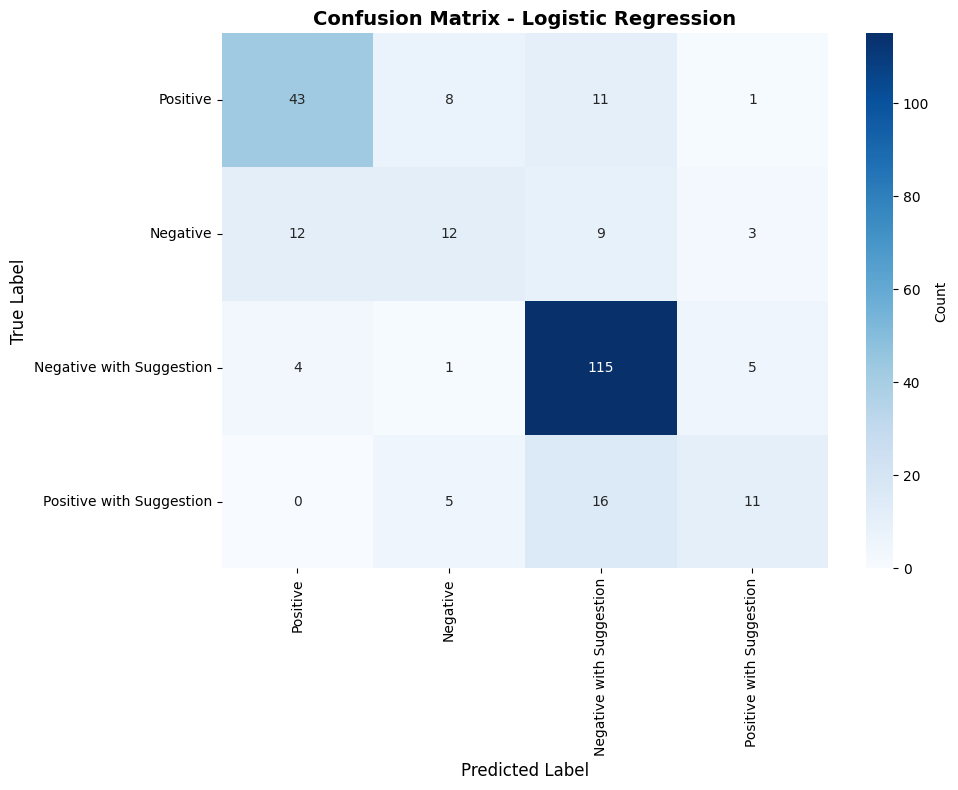

In [15]:
# ========================
# 9. CONFUSION MATRIX
# ========================

best_predictions = models_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved as 'confusion_matrix.png'")

In [16]:
# ========================
# 10. SAVE MODELS
# ========================

print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

# Save best model
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✓ Best model saved as 'sentiment_model.pkl'")

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✓ Vectorizer saved as 'tfidf_vectorizer.pkl'")

# Save all models (optional)
with open('all_models.pkl', 'wb') as f:
    pickle.dump(models_results, f)
print("✓ All models saved as 'all_models.pkl'")



SAVING MODELS
✓ Best model saved as 'sentiment_model.pkl'
✓ Vectorizer saved as 'tfidf_vectorizer.pkl'
✓ All models saved as 'all_models.pkl'


In [17]:
# ========================
# 11. FEATURE IMPORTANCE
# ========================

if best_model_name == 'Logistic Regression':
    print("\n" + "="*60)
    print("TOP 10 FEATURES PER CLASS")
    print("="*60)

    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

    for class_idx, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        coef = best_model.coef_[class_idx]
        top_indices = np.argsort(coef)[-10:][::-1]
        top_features = feature_names[top_indices]
        top_coef = coef[top_indices]

        for feat, coef_val in zip(top_features, top_coef):
            print(f"  • {feat}: {coef_val:.4f}")

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print("\nFiles Created:")
print("  • sentiment_model.pkl")
print("  • tfidf_vectorizer.pkl")
print("  • all_models.pkl")
print("  • confusion_matrix.png")
print("  • model_comparison.csv")


TOP 10 FEATURES PER CLASS

Positive:
  • premium: 5.3986
  • airline: 4.8361
  • spotify: 4.4645
  • flight: 4.2511
  • app: 4.0611
  • everything: 3.8462
  • told: 3.7546
  • netflix: 3.6827
  • cordless: 3.3769
  • gon: 3.3194

Negative:
  • people: 4.8823
  • stop: 4.7950
  • content: 4.7339
  • english: 4.2352
  • removed: 3.8596
  • amp: 3.8152
  • order: 3.7549
  • household: 3.7257
  • doesnt: 3.7078
  • least: 3.6681

Negative with Suggestion:
  • thank: 4.3014
  • corey: 4.0711
  • product: 4.0157
  • best: 3.8012
  • love: 3.6528
  • excellent: 3.2385
  • recommend: 3.2221
  • exactly: 3.2102
  • wallet: 3.1734
  • easy: 3.1050

Positive with Suggestion:
  • wish: 6.8378
  • would: 5.9030
  • however: 5.4718
  • guide: 4.9673
  • thing: 4.6422
  • good: 4.2271
  • charging: 4.1226
  • little: 3.9400
  • sections: 3.8300
  • proof: 3.7081

✅ TRAINING COMPLETE!

Files Created:
  • sentiment_model.pkl
  • tfidf_vectorizer.pkl
  • all_models.pkl
  • confusion_matrix.png
  • mode